# CoxNet - Stability analysis

In [91]:
################################################################################
# SET UP
################################################################################

import os
import sys
import time
import numpy as np
import pandas as pd
import joblib
import pickle
from collections import Counter
#from sksurv.util import Surv
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
os.chdir(os.path.expanduser("~/PhD_Workspace/PredictRecurrence/"))

# Import custom CoxNet functions
sys.path.append("/Users/le7524ho/PhD_Workspace/PredictRecurrence/src/")
from src.utils import (
    log,
    load_training_data,
    beta2m,
    subset_methylation)
from src.annotation_functions import (
    run_univariate_cox_for_cpgs
)

In [ ]:
################################################################################
# INPUT FILES
################################################################################

infile_map = {
    "ERpHER2n_Clinical" : "./output/CoxNet/ERpHER2n/Clinical/None/outer_cv_models.pkl", 
    "ERpHER2n_Combined" : "./output/CoxNet/ERpHER2n/Combined/Unadjusted/outer_cv_models.pkl",
    "ERpHER2n_Methylation" : "./output/CoxNet/ERpHER2n/Methylation/Unadjusted/outer_cv_models.pkl",

    "TNBC_Clinical" : "./output/CoxNet/TNBC/Clinical/None/outer_cv_models.pkl",
    "TNBC_Combined" : "./output/CoxNet/TNBC/Combined/Unadjusted/outer_cv_models.pkl", 
    "TNBC_Methylation" : "./output/CoxNet/TNBC/Methylation/Unadjusted/outer_cv_models.pkl", 

    "All_Clinical" : "./output/CoxNet/All/Clinical/None/outer_cv_models.pkl", 
    "All_Combined" : "./output/CoxNet/All/Combined/Unadjusted/outer_cv_models.pkl", 
    "All_Methylation" : "./output/CoxNet/All/Methylation/Unadjusted/outer_cv_models.pkl" 
}

In [93]:

################################################################################
# PARAMS
################################################################################

# Output directory and files
output_dir = "output/CoxNet/Stability_analysis/" # ⚠️ ADAPT
os.makedirs(output_dir, exist_ok=True)
#outfile_univariate_cox = os.path.join(output_dir, "testset_univariate_cox.csv")


In [94]:
infile_map.items()

dict_items([('ERpHER2n_Clinical', './output/CoxNet/ERpHER2n/Clinical/None/outer_cv_models.pkl'), ('ERpHER2n_Combined', './output/CoxNet/ERpHER2n/Combined/Unadjusted/outer_cv_models.pkl'), ('ERpHER2n_Methylation', './output/CoxNet/ERpHER2n/Methylation/Unadjusted/outer_cv_models.pkl'), ('TNBC_Clinical', './output/CoxNet/TNBC/Clinical/None/outer_cv_models.pkl'), ('TNBC_Combined', './output/CoxNet/TNBC/Combined/Unadjusted/outer_cv_models.pkl'), ('TNBC_Methylation', './output/CoxNet/TNBC/Methylation/Unadjusted/outer_cv_models.pkl'), ('All_Clinical', './output/CoxNet/All/Clinical/None/outer_cv_models.pkl'), ('All_Combined', './output/CoxNet/All/Combined/Unadjusted/outer_cv_models.pkl'), ('All_Methylation', './output/CoxNet/All/Methylation/Unadjusted/outer_cv_models.pkl')])

In [95]:
outerfolds = {}
for key, filepath in infile_map.items():
    outerfolds[key] = joblib.load(filepath)


In [96]:
outerfolds['ERpHER2n_Clinical'][0].keys()

dict_keys(['fold', 'model', 'train_idx', 'test_idx', 'train_ids', 'test_ids', 'cv_results', 'features_after_filter1', 'features_after_filter2', 'input_training_features', 'features_in_model', 'error'])

In [97]:
for cohort_sub, fold_dicts in outerfolds.items():
    print(f"{cohort_sub} with {len(fold_dicts)}")
    #for folddict in fold_dicts:
        #print(folddict["model"])

ERpHER2n_Clinical with 10
ERpHER2n_Combined with 10
ERpHER2n_Methylation with 10
TNBC_Clinical with 10
TNBC_Combined with 10
TNBC_Methylation with 10
All_Clinical with 10
All_Combined with 10
All_Methylation with 10


In [98]:
# access via dictionary # features_in_model
for cohort_sub, fold_dicts in outerfolds.items():
    print(f"{cohort_sub}")
    if "Clinical" in cohort_sub:
        for folddict in fold_dicts:
            print(len(folddict["features_in_model"]))
                    #print(f"{len(fold_dicts)}")

ERpHER2n_Clinical
6
6
7
7
7
7
7
7
6
6
ERpHER2n_Combined
ERpHER2n_Methylation
TNBC_Clinical
6
6
6
6
6
6
6
6
6
6
TNBC_Combined
TNBC_Methylation
All_Clinical
7
6
7
7
7
7
7
6
7
7
All_Combined
All_Methylation


## Stability analysis

### Within Subcohort - Model type

In [103]:
# decide for which cohort to run
cohorts = ["All_Methylation", "TNBC_Methylation", "ERpHER2n_Methylation"] # ["All_Methylation"] # ["All_Clinical", "All_Combined", "All_Methylation"]

all_fold_dicts = []
for cohort in cohorts:
    all_fold_dicts.extend(outerfolds[cohort])  # collect all fold dicts

#### Variance filter stability

In [104]:
# Flatten all features after the first filter
all_features = [f for fold in all_fold_dicts for f in fold["features_after_filter1"]]

# Count frequency of each feature
feature_counts = Counter(all_features)

# Convert to dataframe
feature_freq_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency'])
feature_freq_df.sort_values('Frequency', ascending=False, inplace=True)

# Group features by frequency and sort descending
features_by_frequency = feature_freq_df.groupby('Frequency').apply(lambda x: list(x.index))
features_by_frequency = features_by_frequency.sort_index(ascending=False)

# Create summary dataframe
selection_summary_df = pd.DataFrame({
    'Number of folds selected': features_by_frequency.index,
    'Number of features': features_by_frequency.apply(len).values
    #'Feature Names': features_by_frequency.apply(lambda x: ", ".join(x)).values
})

print(selection_summary_df)


    Number of folds selected  Number of features
0                         30                7278
1                         29                 456
2                         28                 254
3                         27                 207
4                         26                 158
5                         25                 157
6                         24                 149
7                         23                 163
8                         22                 175
9                         21                 224
10                        20                9272
11                        19                 405
12                        18                 219
13                        17                 186
14                        16                 169
15                        15                 150
16                        14                 165
17                        13                 187
18                        12                 191
19                  

/var/folders/xz/b6r_gs810sx3539tsfsrk8w80000gp/T/ipykernel_31809/2357161398.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_by_frequency = feature_freq_df.groupby('Frequency').apply(lambda x: list(x.index))


#### For model selected features

In [105]:
# Flatten all features
all_features = [f for fold in all_fold_dicts for f in fold["features_in_model"]]

# Count frequency of each feature
feature_counts = Counter(all_features)

# Convert to dataframe
feature_freq_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency'])
feature_freq_df.sort_values('Frequency', ascending=False, inplace=True)

# Group features by frequency and sort descending
features_by_frequency = feature_freq_df.groupby('Frequency').apply(lambda x: list(x.index))
features_by_frequency = features_by_frequency.sort_index(ascending=False)

# Create summary dataframe
selection_summary_df = pd.DataFrame({
    'Number of folds selected': features_by_frequency.index,
    'Number of features': features_by_frequency.apply(len).values
})

print(selection_summary_df)
print(features_by_frequency.values)


    Number of folds selected  Number of features
0                         20                   1
1                         19                   3
2                         17                   1
3                         16                   3
4                         13                   1
5                         12                   1
6                         11                   3
7                         10                   5
8                          9                  13
9                          8                   5
10                         7                   5
11                         6                  10
12                         5                  12
13                         4                  32
14                         3                  44
15                         2                  82
16                         1                 249
[list(['cg24725146']) list(['cg18019042', 'cg08111414', 'cg05966978'])
 list(['cg05434809']) list(['cg17082719', 'cg03

/var/folders/xz/b6r_gs810sx3539tsfsrk8w80000gp/T/ipykernel_31809/3302377078.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_by_frequency = feature_freq_df.groupby('Frequency').apply(lambda x: list(x.index))


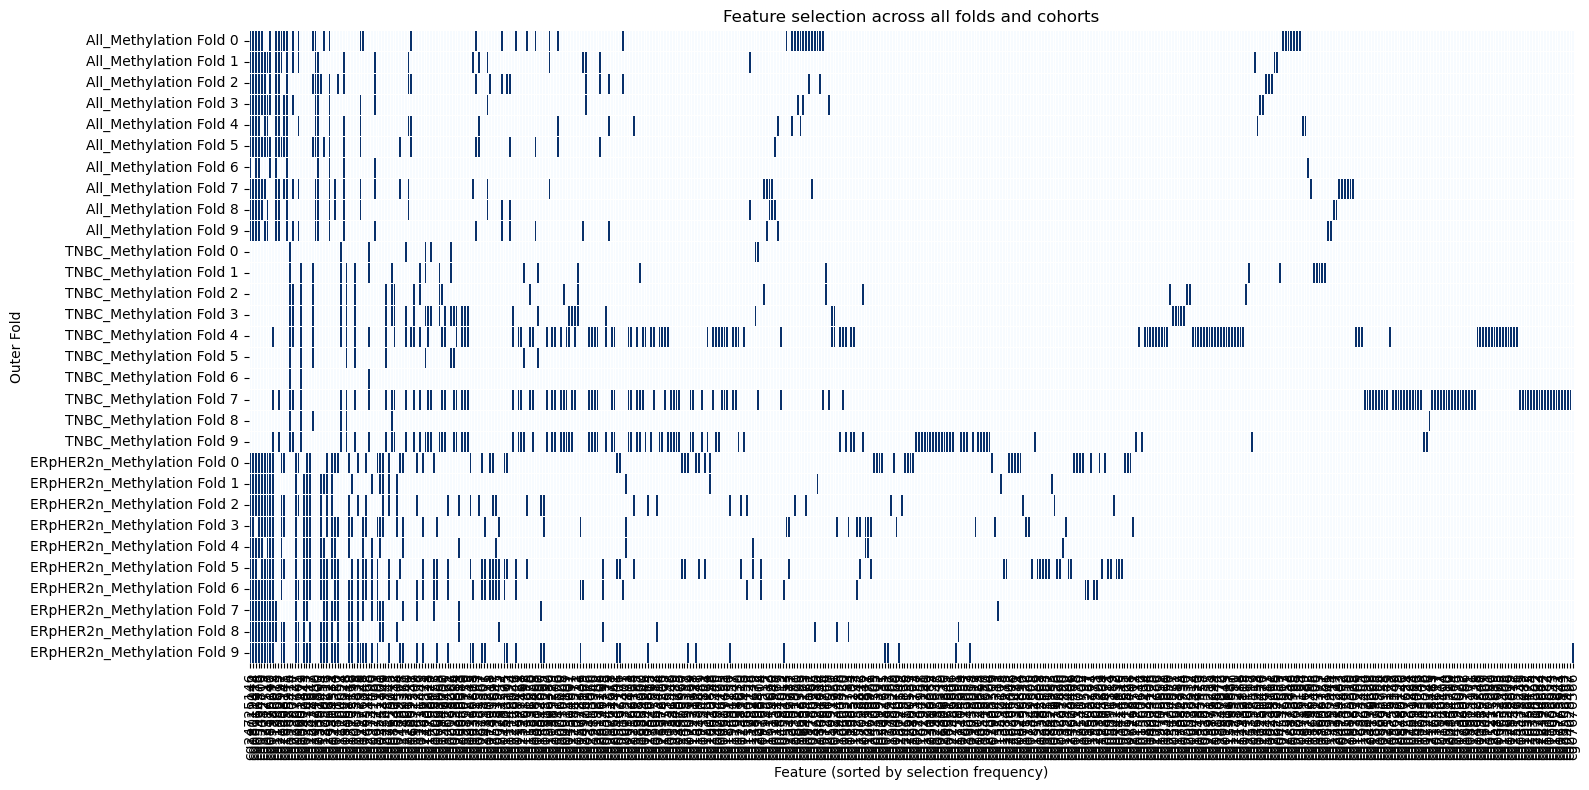

In [106]:
# Flatten all features across all folds
all_features = [f for fold in all_fold_dicts for f in fold["features_in_model"]]

# Count frequency of each feature
feature_counts = Counter(all_features)
feature_freq_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency'])
feature_freq_df.sort_values('Frequency', ascending=False, inplace=True)

# Sort features by frequency
sorted_features = feature_freq_df.index.tolist()

# Build fold x feature matrix
fold_matrix = np.zeros((len(all_fold_dicts), len(sorted_features)))
for i, fold in enumerate(all_fold_dicts):
    for j, feat in enumerate(sorted_features):
        if feat in fold["features_in_model"]:
            fold_matrix[i, j] = 1

# Create row labels combining cohort name and fold number
row_labels = []
for cohort in cohorts:
    fold_dicts = outerfolds[cohort]
    row_labels.extend([f"{cohort} Fold {i}" for i in range(len(fold_dicts))])

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    fold_matrix,
    annot=False,
    cbar=False,
    cmap="Blues",
    xticklabels=sorted_features,
    yticklabels=row_labels,
    linewidths=0.5
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Feature (sorted by selection frequency)")
plt.ylabel("Outer Fold")
plt.title("Feature selection across all folds and cohorts")
plt.tight_layout()
plt.show()
